In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# For machine learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time

In [42]:
# -----------------------------------------------------------
# Define the loading function (provided by competition)
# -----------------------------------------------------------
def load_h5py_file(file_path):
    # Your provided loading code goes here... (as in your prompt)
    data = {
        'neural_features': [],
        'n_time_steps': [],
        'seq_class_ids': [],
        'seq_len': [],
        'transcriptions': [],
        'sentence_label': [],
        'session': [],
        'block_num': [],
        'trial_num': [],
    }
    with h5py.File(file_path, 'r') as f:
        keys = list(f.keys())
        for key in keys:
            g = f[key]
            # ... (rest of your provided loading logic)
            neural_features = g['input_features'][:]
            n_time_steps = g.attrs['n_time_steps']
            seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
            transcription = g['transcription'][:] if 'transcription' in g else None
            
            data['neural_features'].append(neural_features)
            data['n_time_steps'].append(n_time_steps)
            data['seq_class_ids'].append(seq_class_ids)
            data['transcriptions'].append(transcription)
            # ... (append remaining attributes)
            data['seq_len'].append(g.attrs['seq_len'] if 'seq_len' in g.attrs else None)
            data['sentence_label'].append(g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None)
            data['session'].append(g.attrs['session'])
            data['block_num'].append(g.attrs['block_num'])
            data['trial_num'].append(g.attrs['trial_num'])
            
    return data

# -----------------------------------------------------------
# Load a Sample File
# NOTE: Replace 'path/to/data_train.hdf5' with the actual file path.
# -----------------------------------------------------------
file_path = '/Users/armina/Downloads/hdf5_data_final/t15.2023.09.01/data_train.hdf5' 
try:
    raw_data = load_h5py_file(file_path)
    print(f"Data loaded for {len(raw_data['neural_features'])} trials.")
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{file_path}'. Please check the path.")
    
# Convert to DataFrame for easier inspection
df = pd.DataFrame({k: raw_data[k] for k in ['transcriptions', 'n_time_steps', 'seq_len', 'session', 'block_num']})

Data loaded for 297 trials.


In [46]:
import numpy as np
import time

def run_data_sanity_check(raw_data):
    """
    Performs critical checks for non-finite values (NaN/Inf) and data shape
    on all loaded trials.
    """
    print("========================================================")
    print("✅ STARTING DATA SANITY CHECK...")
    print("========================================================")
    start_time = time.time()
    
    # ------------------------------------------------------------------
    # 1. CHECK NEURAL FEATURES (X)
    # ------------------------------------------------------------------
    print("Checking Neural Features (X) for NaN/Inf values...")
    
    total_non_finite = 0
    corrupt_trials = []
    
    for i, features in enumerate(raw_data['neural_features']):
        # Count non-finite values (NaN or Inf)
        non_finite_mask = ~np.isfinite(features)
        count = np.sum(non_finite_mask)
        
        if count > 0:
            total_non_finite += count
            corrupt_trials.append(i)
            print(f"  ❌ Trial {i}: Found {count} non-finite feature values.")
            
        # Basic check on feature dimension
        if features.shape[1] != 512:
            print(f"  ⚠️ Trial {i}: Expected 512 features, found {features.shape[1]}. Skipping NaN/Inf check.")

    if total_non_finite == 0:
        print("  🎉 Neural Features (X): All trials are clean (no NaN/Inf found).")
    else:
        print(f"\n🚨 ALERT: Total {total_non_finite} corrupted feature values found across {len(corrupt_trials)} trials.")
        
    print("-" * 50)
    
    # ------------------------------------------------------------------
    # 2. CHECK TARGET SEQUENCES (Y)
    # ------------------------------------------------------------------
    print("Checking Target IDs (Y) for NaN/Inf/Negative values...")

    # We only need to check seq_class_ids as transcriptions are raw bytes/chars
    invalid_ids_count = 0
    invalid_y_trials = []

    for i, ids in enumerate(raw_data['seq_class_ids']):
        if ids is None:
             print(f"  ❌ Trial {i}: seq_class_ids is None. Corrupt target.")
             invalid_ids_count += 1
             invalid_y_trials.append(i)
             continue
        
        # Check for non-integer (NaN/Inf) or negative IDs (which shouldn't exist)
        if np.any(~np.isfinite(ids)) or np.any(ids < 0):
            invalid_ids_count += 1
            invalid_y_trials.append(i)
            print(f"  ❌ Trial {i}: Found invalid phoneme IDs (NaN/Inf/Negative).")

    if invalid_ids_count == 0:
        print("  🎉 Target IDs (Y): All trials contain valid, positive integer IDs.")
    else:
        print(f"\n🚨 ALERT: Total {invalid_ids_count} trials found with corrupted or missing target IDs.")

    # ------------------------------------------------------------------
    # 3. FINAL SUMMARY
    # ------------------------------------------------------------------
    end_time = time.time()
    print("-" * 50)
    print(f"Sanity Check Complete. Time taken: {end_time - start_time:.2f} seconds.")
    print("========================================================")

# --- EXECUTION ---
# Assuming your previously loaded data (e.g., from one HDF5 file) is stored in 'raw_data'
# Run the check:
run_data_sanity_check(raw_data)

✅ STARTING DATA SANITY CHECK...
Checking Neural Features (X) for NaN/Inf values...
  🎉 Neural Features (X): All trials are clean (no NaN/Inf found).
--------------------------------------------------
Checking Target IDs (Y) for NaN/Inf/Negative values...
  🎉 Target IDs (Y): All trials contain valid, positive integer IDs.
--------------------------------------------------
Sanity Check Complete. Time taken: 0.32 seconds.


In [47]:
import numpy as np
import time

def run_amplitude_sanity_check(raw_data, z_score_threshold=10):
    """
    Checks if any trial's neural features exceed a strict amplitude threshold (Z-score).
    
    Args:
        raw_data (dict): Your loaded data dictionary.
        z_score_threshold (int): Max allowed amplitude in standard deviations.
    """
    print("========================================================")
    print("📈 STARTING AMPLITUDE OUTLIER CHECK...")
    print("========================================================")
    start_time = time.time()
    
    all_features = np.concatenate(raw_data['neural_features'], axis=0).flatten()
    
    # 1. Calculate Global Statistics on the ENTIRE loaded dataset
    mean_global = np.mean(all_features[np.isfinite(all_features)])
    std_global = np.std(all_features[np.isfinite(all_features)])
    
    if std_global == 0:
        print("  ⚠️ Global Standard Deviation is zero. Cannot perform Z-score check.")
        return

    print(f"  Global Mean: {mean_global:.2f}, Global Std Dev: {std_global:.2f}")
    print(f"  Threshold (Z={z_score_threshold}): Max acceptable amplitude ≈ {mean_global + z_score_threshold * std_global:.2f}")
    
    # 2. Iterate and Check Trials
    outlier_trials = []
    
    for i, features in enumerate(raw_data['neural_features']):
        # Standardize the features relative to the global mean/std
        z_scores = np.abs((features - mean_global) / std_global)
        
        # Check if the maximum Z-score in this trial exceeds the threshold
        if np.max(z_scores) > z_score_threshold:
            outlier_trials.append(i)
            print(f"  ❌ Trial {i}: Max Z-score of {np.max(z_scores):.2f} exceeds threshold {z_score_threshold}.")

    if not outlier_trials:
        print(f"  🎉 Amplitude Check: All trials pass the Z-score < {z_score_threshold} threshold.")
    else:
        print(f"\n🚨 ALERT: {len(outlier_trials)} trials flagged as potential outliers due to extreme amplitude.")
        print("  These trials should be inspected or excluded from training.")

    end_time = time.time()
    print(f"Amplitude Check Complete. Time taken: {end_time - start_time:.2f} seconds.")
    print("========================================================")

# --- EXECUTION ---
# Run the check:
run_amplitude_sanity_check(raw_data, z_score_threshold=10) # Using 10 is very strict

📈 STARTING AMPLITUDE OUTLIER CHECK...
  Global Mean: -0.00, Global Std Dev: 1.00
  Threshold (Z=10): Max acceptable amplitude ≈ 9.99
  ❌ Trial 0: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 1: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 2: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 3: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 4: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 5: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 6: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 7: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 8: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 9: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 10: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 11: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 12: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 13: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 14: Max Z-score of 10.01 exceeds threshold 10.
  ❌ Trial 15: Max Z-sc

/Users/armina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


52


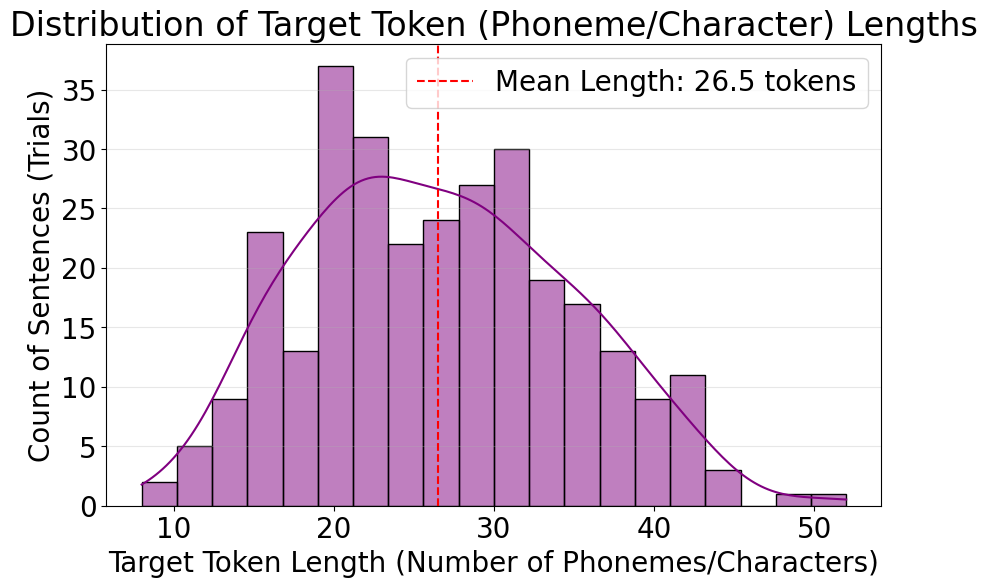

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# The DataFrame 'df' containing all 297 trials must be available in your notebook.

plt.figure(figsize=(10, 6))
# Plot the distribution of the 'seq_len' column
sns.histplot(df['seq_len'], bins=20, kde=True, color='purple')

# Calculate and plot the mean length
mean_length = df['seq_len'].mean()
print(df['seq_len'].max())
plt.axvline(mean_length, color='red', linestyle='--', 
            label=f'Mean Length: {mean_length:.1f} tokens')

plt.title('Distribution of Target Token (Phoneme/Character) Lengths')
plt.xlabel('Target Token Length (Number of Phonemes/Characters)')
plt.ylabel('Count of Sentences (Trials)')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Save the final figure for your presentation
output_filename = '/Users/armina/Desktop/target_length_distribution_final.png'
plt.savefig(output_filename, dpi=300) 
plt.show()

In [3]:
# Check the shape of the first trial's neural features
first_trial_X = raw_data['neural_features'][0]
print(f"First Trial Neural Features (X) Shape: {first_trial_X.shape}") 
# Expected: (Time_Steps, Features_per_Step) e.g., (180, 512)

# Check the transcription (text/phonemes)
first_trial_Y = raw_data['transcriptions'][0]
# Transcriptions are loaded as an array of ASCII codes, convert them to a string
decoded_transcription = ''.join(chr(c) for c in first_trial_Y)
print(f"First Trial Transcription (Y): '{decoded_transcription}'")
print(f"First Trial Target Length: {len(decoded_transcription)}") 
# Expected: A string of characters/phonemes/tokens

print(f"\nTime steps (neural signal length) Summary:")
print(df['n_time_steps'].describe())
print(f"\nSequence length (transcription length) Summary:")
print(df['seq_len'].describe())

First Trial Neural Features (X) Shape: (451, 512)
First Trial Transcription (Y): 'The financial planners.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             '
First Trial Target Length: 500

Time steps (neural signal length) Summary:
count     297.000000
mean      804.289562
std       237.304921
min       324.000000
25%       637.000000
50%       779.000000
75%       952.000000
max      1612.000000
Name: n_time_steps, dtype: float64

Sequence length (transcription length) Summary:
count    297.000000
mean      26.521886
std        8.223259
min        8.000000
25%      

In [5]:
N_trials_to_plot = 50
all_features = np.concatenate(raw_data['neural_features'][:N_trials_to_plot], axis=0).flatten()

# Check for non-finite values
finite_mask = np.isfinite(all_features)
n_non_finite = np.sum(~finite_mask)

if n_non_finite > 0:
    print(f"WARNING: {n_non_finite} non-finite values found ({n_non_finite/len(all_features)*100:.4f}% of data).")
    # Filter the features to only keep finite values for plotting
    clean_features = all_features[finite_mask]
else:
    clean_features = all_features
    print("All features are finite. Proceeding with visualization.")

All features are finite. Proceeding with visualization.


/Users/armina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


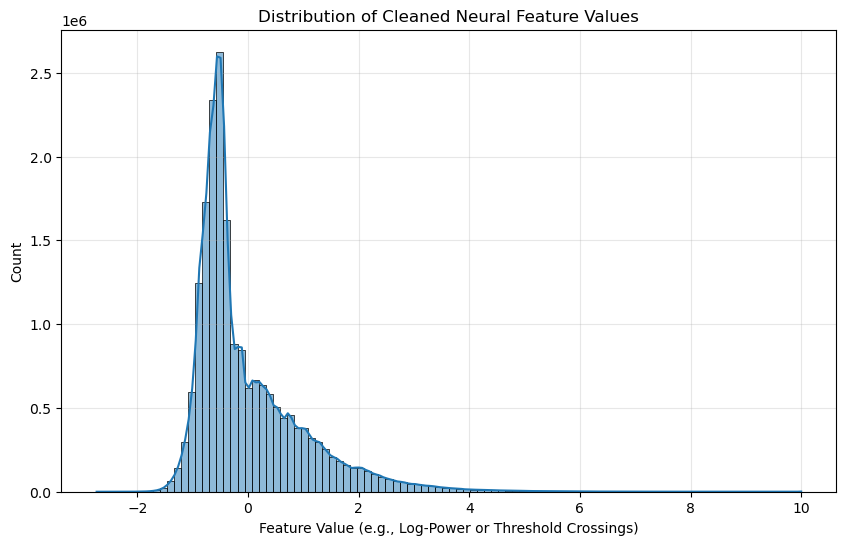

In [6]:
clean_features_df = pd.DataFrame({'Feature Value': clean_features})

plt.figure(figsize=(10, 6))

# Plot the distribution
# We remove 'log_scale=True' from histplot because it can be sensitive
# to feature distributions that include zero or negative values.
# If you want to show the count distribution on a log scale, use log=True in the matplotlib axes.
sns.histplot(clean_features_df['Feature Value'], bins=100, kde=True)

plt.title('Distribution of Cleaned Neural Feature Values')
plt.xlabel('Feature Value (e.g., Log-Power or Threshold Crossings)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# If the data is highly skewed (likely for power/spike features),
# you might still want to try a log scale on the Y-axis:
# plt.yscale('log')
# plt.ylabel('Count (Log Scale)')

plt.show()
# 

Figure successfully saved as /Users/armina/Desktop/neural_features_isolated_large.png


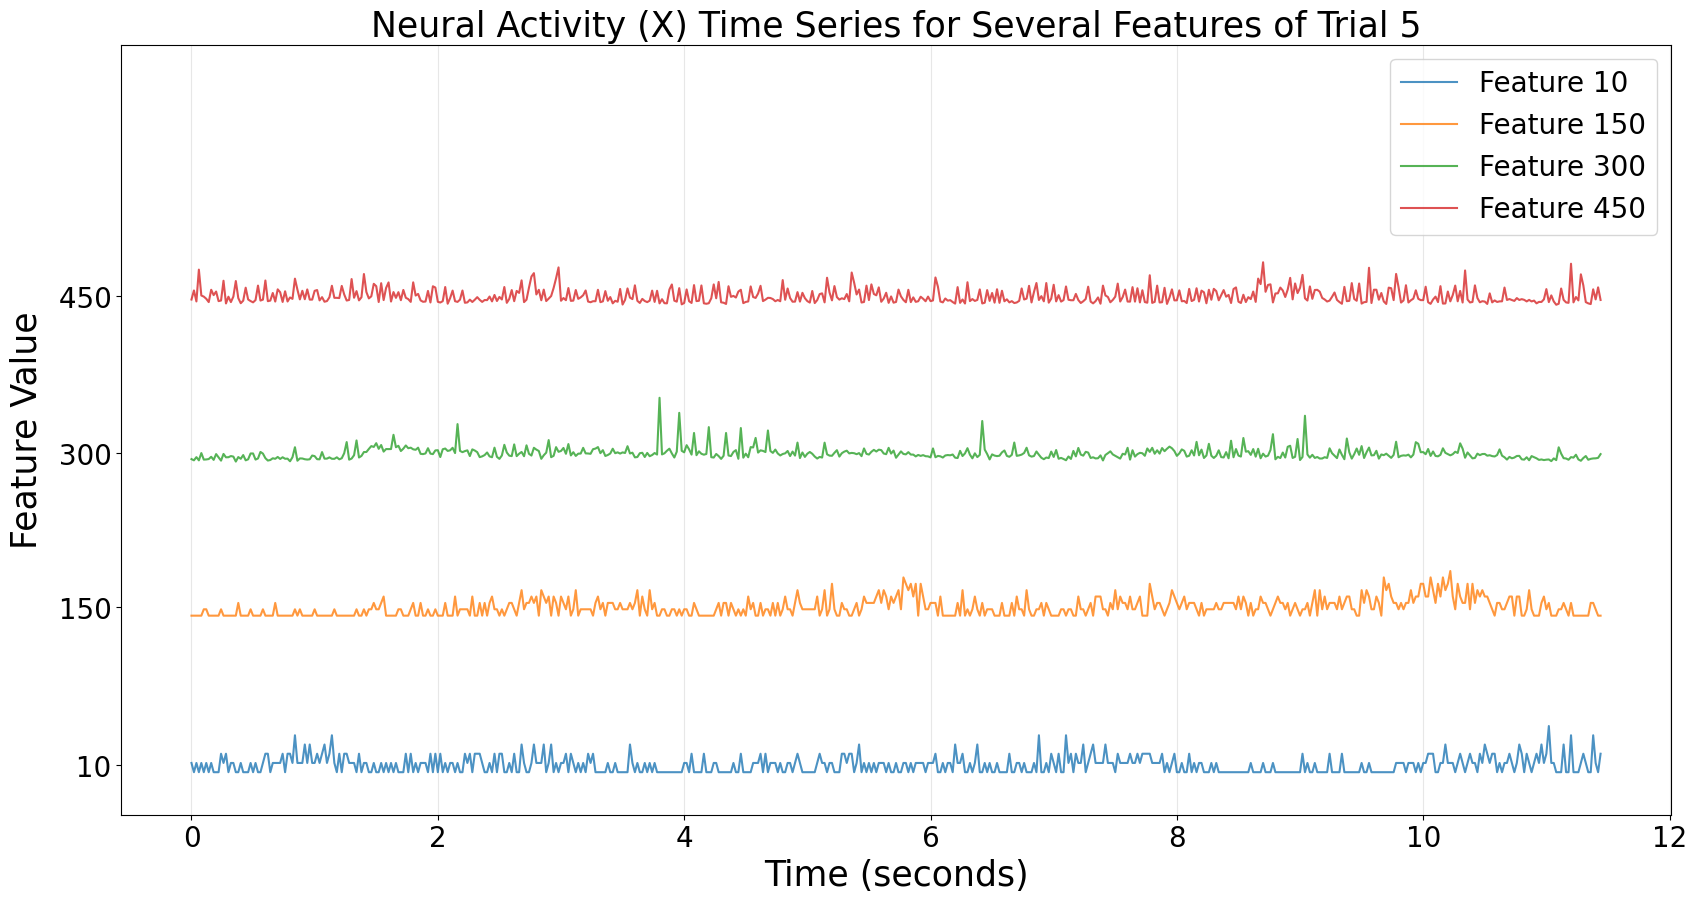

In [34]:
# ----------------------------------------------------------------------
# 1. Helper Function to Decode Transcription
# ----------------------------------------------------------------------
def decode_transcription(transcription_array):
    """Converts a numpy array of character codes/bytes into a readable string."""
    # Assuming the array contains ASCII/UTF-8 integer codes for characters
    try:
        # Convert the numpy array to a list of integers, then to characters, then join
        return ''.join(chr(c) for c in transcription_array.flatten())
    except:
        # Fallback if it's already a bytes object (less likely given your error)
        try:
            return transcription_array.decode('utf-8')
        except:
            # If it's something else, just return a placeholder
            return "DEC_ERROR"

# ----------------------------------------------------------------------
# 2. Corrected Visualization Code
# ----------------------------------------------------------------------

trial_index = 5 # Example trial
# Select a few features/channels from different parts of the 512-feature array
features_to_plot = [10, 150, 300, 450] 
X_data = raw_data['neural_features'][trial_index]
time_steps = np.arange(X_data.shape[0]) * 20 / 1000 # 20ms bins to seconds

# *** FIX APPLIED HERE ***
#decoded_title_text = decode_transcription(raw_data['transcriptions'][trial_index])
# ------------------------

plt.figure(figsize=(20, 10))

for i, feature_idx in enumerate(features_to_plot):
    # Plot each feature with an offset for clarity (staggered plot)
    offset = i * 20 # Arbitrary offset to separate lines
    
    plt.plot(time_steps, X_data[:, feature_idx] + offset, 
             label=f'Feature {feature_idx}', alpha=0.8, linewidth=1.5)

# Highlight where the speech attempt is happening (if known, but generally covers the trial duration)
#plt.axvspan(0.5, time_steps[-1], color='red', alpha=0.1, label='Approx. Speech Window')

# Set custom Y-ticks for the staggered plots
plt.yticks(np.array([X_data[:, idx].mean() + i*20 for i, idx in enumerate(features_to_plot)]), 
           [f' {idx}' for idx in features_to_plot])
plt.ylim(X_data[:, features_to_plot].min() - 5, X_data[:, features_to_plot].max() + len(features_to_plot) * 20 + 5)


# Use the correctly decoded string in the title
plt.title(f"Neural Activity (X) Time Series for Several Features of Trial {trial_index}", fontsize=25)
plt.xlabel('Time (seconds)', fontsize=25)
plt.ylabel('Feature Value', fontsize=25)
plt.legend(loc='upper right')
plt.grid(axis='x', alpha=0.3)

output_filename = '/Users/armina/Desktop/neural_features_isolated_large.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight') 
print(f"Figure successfully saved as {output_filename}")

plt.show()
#

It's kind of rainy actually.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
Figure successfully saved as /Users/armina/Desktop/neural_features_heatmap_large.png


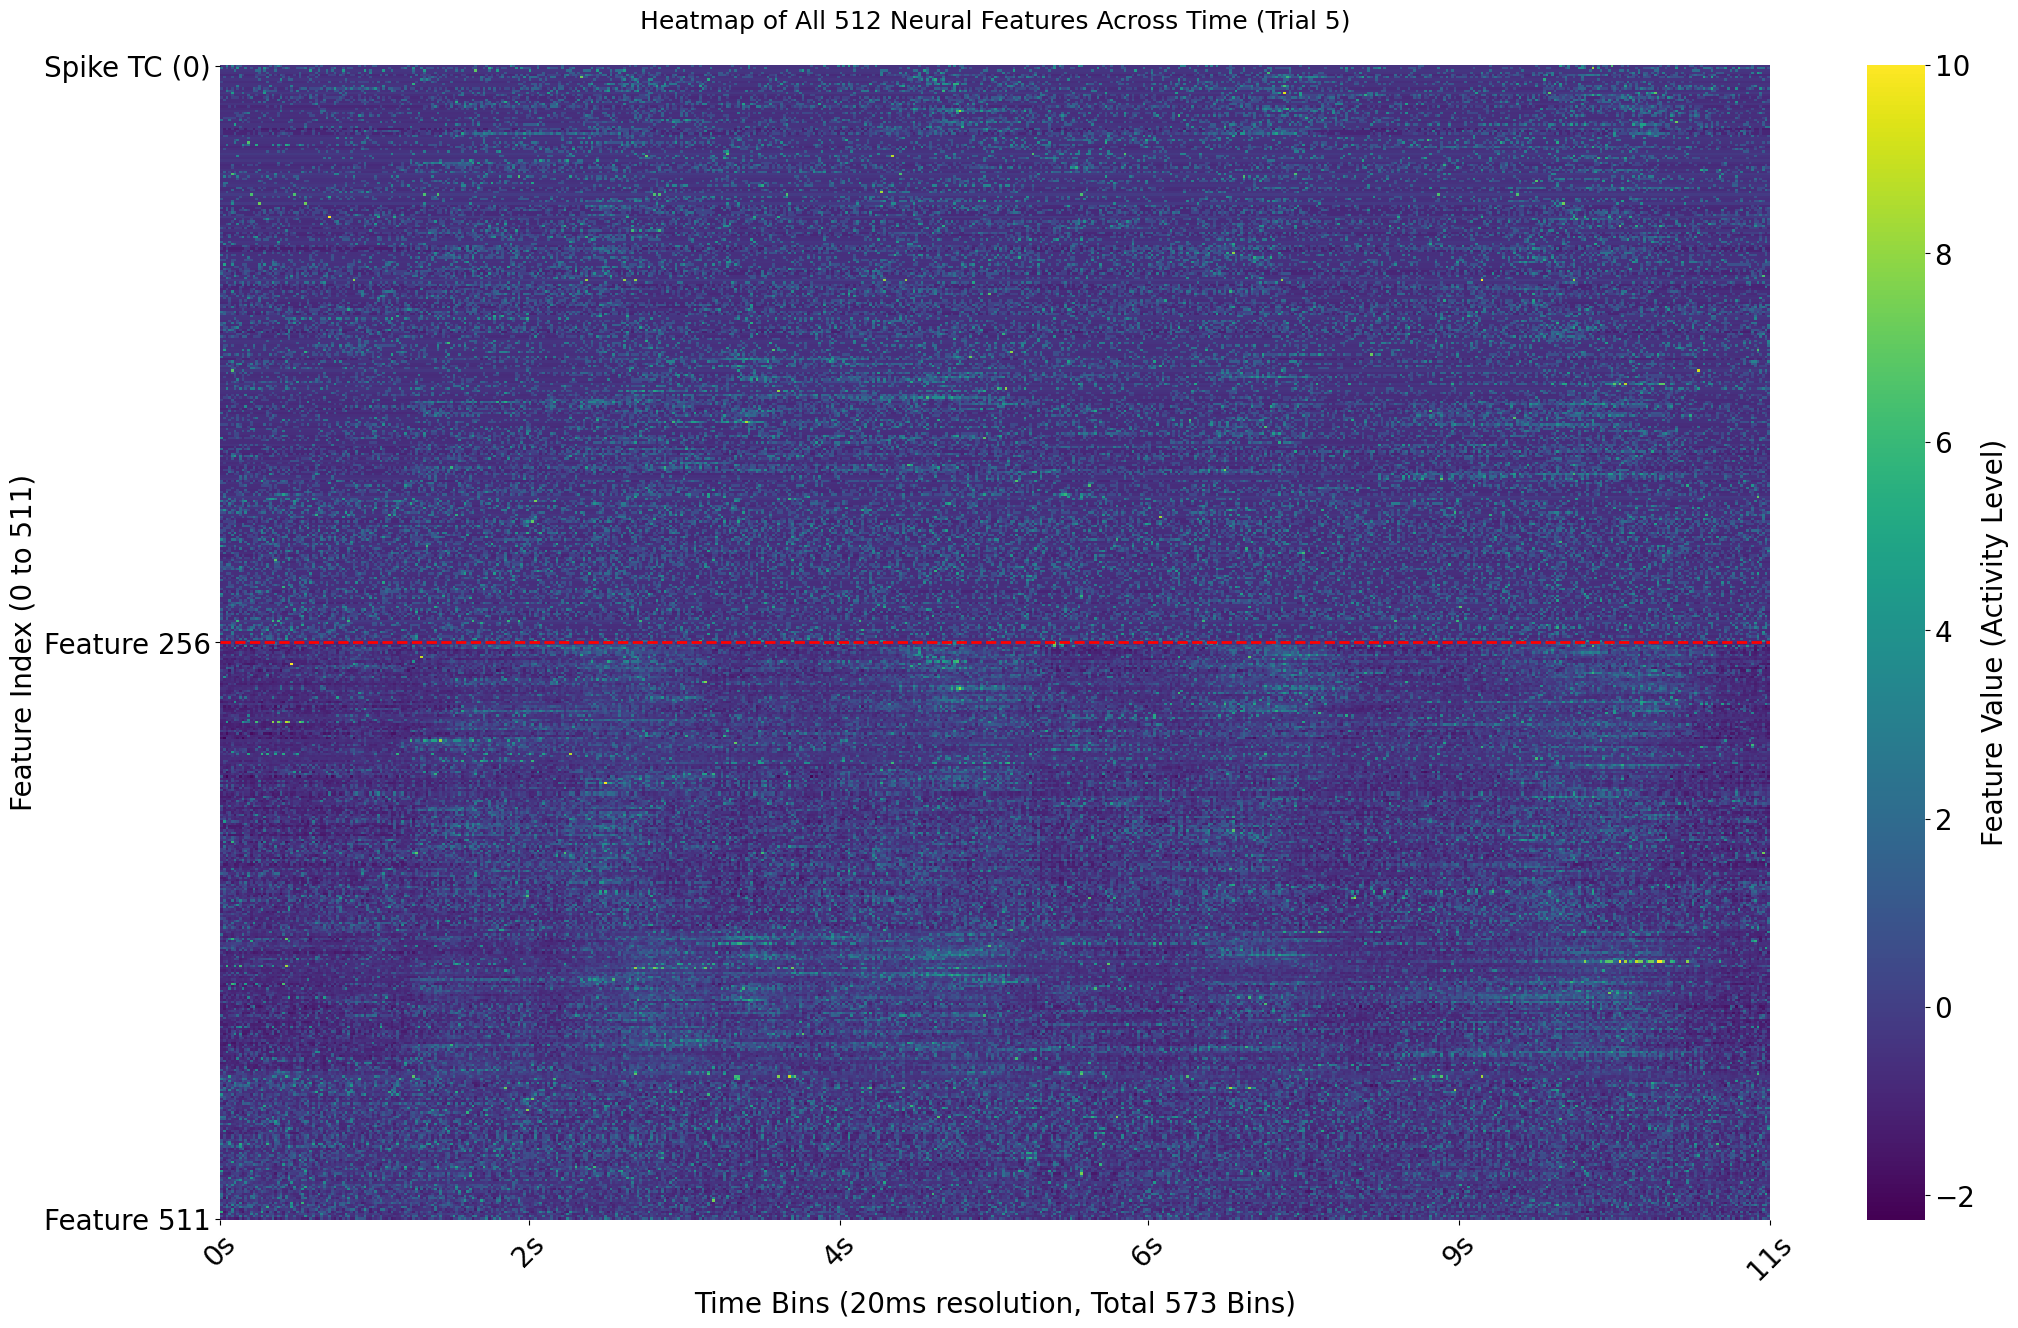

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function (ensures transcription is correctly decoded)
def decode_transcription(transcription_array):
    """Converts a numpy array of character codes/bytes into a readable string."""
    try:
        return ''.join(chr(c) for c in transcription_array.flatten())
    except:
        return "DEC_ERROR"

# ----------------------------------------------------------------------
# 1. SETUP: Adjust Global Parameters and Prepare Data
# ----------------------------------------------------------------------
original_rcParams = plt.rcParams.copy()
# Reduce default font size to give labels room without making plot area tiny
plt.rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'xtick.labelsize':20, 'ytick.labelsize': 20})

trial_index = 5 
X_data = raw_data['neural_features'][trial_index]
decoded_title_text = decode_transcription(raw_data['transcriptions'][trial_index])
print(decoded_title_text)
heatmap_data = X_data.T
num_features = heatmap_data.shape[0]
num_time_bins = heatmap_data.shape[1]

# ----------------------------------------------------------------------
# 2. Plotting the Heatmap with Explicit Tick Control
# ----------------------------------------------------------------------
# Use plt.subplots for better control over the figure and axes
fig, ax = plt.subplots(figsize=(25, 15)) 

# Plot the heatmap on the defined axis 'ax'
sns.heatmap(
    heatmap_data, 
    cmap='viridis', 
    ax=ax,  # Plot on the designated axes
    cbar_kws={'label': 'Feature Value (Activity Level)'},
    # KEY FIX 1: Turn off default ticks to prevent the 512 unreadable boxes
    yticklabels=False,
    xticklabels=False 
)

# 3. Custom Ticks and Labels
ax.set_title(
    f'Heatmap of All {num_features} Neural Features Across Time (Trial {trial_index})\n',
    fontsize=18 
)
ax.set_ylabel(f'Feature Index (0 to {num_features-1})', fontsize=20)
ax.set_xlabel(f'Time Bins (20ms resolution, Total {num_time_bins} Bins)', fontsize=20)

# Add separation line
ax.axhline(y=256, color='red', linestyle='--', linewidth=2, label='Separation: Spike Threshold Crossings / Spike Power')

# KEY FIX 2: Manually set only the necessary Y-ticks (to label the feature groups)
ax.set_yticks([0.5, 256, 511.5]) 
ax.set_yticklabels(['Spike TC (0)', 'Feature 256', 'Feature 511'], rotation=0)

# Manually set only the necessary X-ticks (to label time in seconds)
x_tick_positions = np.linspace(0, num_time_bins, 6, dtype=int)
x_tick_labels = [f'{int(t*20/1000)}s' for t in x_tick_positions]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=45)


# ----------------------------------------------------------------------
# 4. RESTORE the original Matplotlib settings
# ----------------------------------------------------------------------
plt.rcParams.update(original_rcParams)

output_filename = '/Users/armina/Desktop/neural_features_heatmap_large.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight') 
print(f"Figure successfully saved as {output_filename}")

plt.show()
#

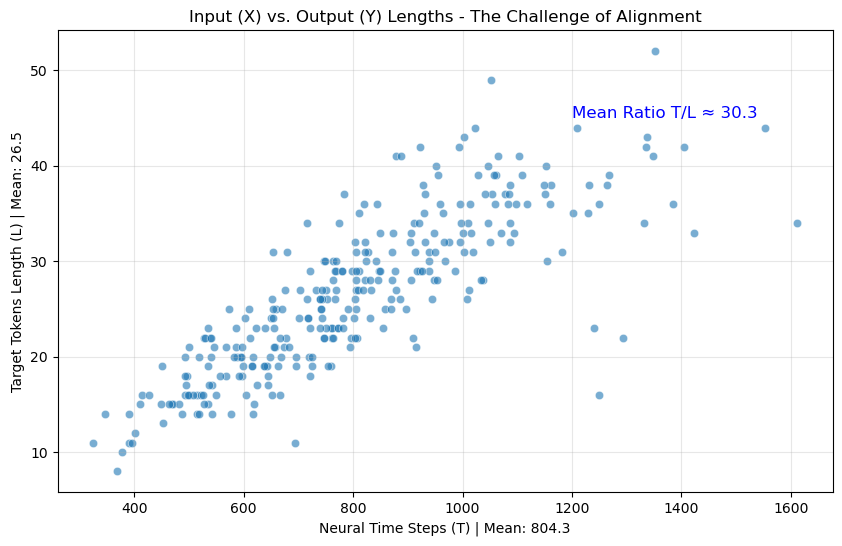

In [8]:
# Create a DataFrame for cleaner plotting
df_lengths = pd.DataFrame({
    'Neural_Time_Steps': raw_data['n_time_steps'], 
    'Target_Tokens_Length': raw_data['seq_len']
})

plt.figure(figsize=(10, 6))
plt.scatter(df_lengths['Neural_Time_Steps'], df_lengths['Target_Tokens_Length'], 
            alpha=0.6, edgecolors='w', linewidths=0.5)

# Add a line to show a 1:1 ratio for contrast
# max_val = max(df_lengths['Neural_Time_Steps'].max(), df_lengths['Target_Tokens_Length'].max())
# plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='1:1 Alignment (Not Observed)')

plt.title('Input (X) vs. Output (Y) Lengths - The Challenge of Alignment')
plt.xlabel(f'Neural Time Steps (T) | Mean: {df_lengths["Neural_Time_Steps"].mean():.1f}')
plt.ylabel(f'Target Tokens Length (L) | Mean: {df_lengths["Target_Tokens_Length"].mean():.1f}')
plt.text(1200, 45, f'Mean Ratio T/L ≈ {df_lengths["Neural_Time_Steps"].mean()/df_lengths["Target_Tokens_Length"].mean():.1f}', 
         fontsize=12, color='blue')
plt.grid(True, alpha=0.3)
plt.show()
#

In [40]:
import numpy as np

# The Vocabulary Map provided by the competition organizers
LOGIT_TO_PHONEME = [
    'BLANK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 
    'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 
    'V', 'W', 'Y', 'Z', 'ZH', ' | '  # "|" = silence token
]

# --- Setup ---
trial_index = 5  # The trial we have been analyzing
target_id_array = raw_data['seq_class_ids'][trial_index]
target_transcription_text = decode_transcription(raw_data['transcriptions'][trial_index])

# 1. Decode the numeric sequence into phoneme symbols
# We use the provided list, which maps the index (ID) to the symbol.
decoded_phoneme_list = [LOGIT_TO_PHONEME[id] for id in target_id_array]
decoded_phoneme_sequence = ' '.join(decoded_phoneme_list)

print("")
# 2. Print Clear Summary
print(f"Decoded Target Sequence for Trial {trial_index}")

print("")
# A. Human-Readable Transcription
print(f"Human Transcription (Reference): '{target_transcription_text}'")

# B. Phoneme Sequence (The Y-Target)
print(f"Decoded Phoneme Sequence (Y-Target):")
print(f" {decoded_phoneme_sequence}")

print("-" * 50)

# C. Properties
print(f"| Sequence Length (Tokens): {len(decoded_phoneme_list)} (Matches seq_len)")
print(f"| Total Vocabulary Size: {len(LOGIT_TO_PHONEME)} (Includes BLANK/Silence)")
print(f"| Unique Phonemes in this trial: {len(np.unique(target_id_array))}")

print("-" * 50)
print("🎯 IMPLICATION FOR MODEL:")
print(f"- The model's final output must be a probability distribution over all {len(LOGIT_TO_PHONEME)} classes.")
print(f"- It must map ~{raw_data['n_time_steps'][trial_index] / len(decoded_phoneme_list):.1f} neural time steps to 1 phoneme/token.")
print("==================================================================")


Decoded Target Sequence for Trial 5

Human Transcription (Reference): 'It's kind of rainy actually.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        '
Decoded Phoneme Sequence (Y-Target):
 IH T S  |  K AY N D  |  AH V  |  R EY N IY  |  AE K CH UW AH L IY  |  BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK BLANK 